In [1]:
import copy
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from math import floor
import logging
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
import math




/home/paarthsachan/miniconda3/envs/battery/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from scipy.ndimage import gaussian_filter1d


In [3]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque


In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

torch.manual_seed(81);


In [5]:
# battery1_path='/kaggle/input/battery-uniform-distribution-charge-discharge/Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post/data/R/RW9.Rda'
# battery2_path='/kaggle/input/battery-uniform-distribution-charge-discharge/Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post/data/R/RW10.Rda'
# battery3_path='/kaggle/input/battery-uniform-distribution-charge-discharge/Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post/data/R/RW11.Rda'
# battery4_path='/kaggle/input/battery-uniform-distribution-charge-discharge/Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post/data/R/RW12.Rda'
from scipy.io import loadmat
annots = loadmat('/home/paarthsachan/EE499_Project/Dataset/Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post/data/Matlab/RW9.mat')
annots_=annots['data'][0][0]
steps=annots_[0][0]
list_filt=[]
for i in range(100000,len(steps)):
    if(steps[i][0][0]=='discharge (random walk)'):
        list_filt.append(i)


In [138]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [146]:
def array_normaliser(array):
    array_new=(array-array.min()+1e-7)/(array.max()-array.min()+1e-7)
    return array_new
def data_norm(data,select_ele):
    data[:,0]=array_normaliser(data[:,0])
    data[:,1]=array_normaliser(data[:,1])
    data[:,2]=array_normaliser(data[:,2])
    data[:,3]=array_normaliser(data[:,3])
    elements=np.arange(data.shape[0])
    elements_=np.random.choice(elements,select_ele)
    
    #print(data[elements_].shape,"$$$$$$$$$$$$")
    return data[elements_]
def data_norm0(data,select_ele):
    elements=np.arange(data.shape[0])
    elements_=np.random.choice(elements,select_ele)
    
    #print(data[elements_].shape,"$$$$$$$$$$$$")
    return data[elements_]
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    min_amount=min(x.shape[0],y.shape[0])
    x_indices=np.random.choice(len(x),min_amount)
    y_indices=np.random.choice(len(y),min_amount)

    x=x[x_indices]
    y=y[y_indices]
    x=torch.Tensor(x)
    y=torch.Tensor(y)
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)


In [147]:
def norm_give_all_data(steps,step_index):
    step=steps[step_index]
    time_array=step[3][0]

    non_relative_time=step[2][0]
    voltage_array=step[4][0]
    current_array=step[5][0]
    temperature_array=step[6][0]

    voltage_normalised=array_normaliser(voltage_array)
    current_normalised=array_normaliser(current_array)
    nol_rel_normalised=array_normaliser(non_relative_time)
    time_normalised=array_normaliser(time_array)
    temperature_normalised=array_normaliser(temperature_array)
    
    all_data=np.stack((voltage_normalised,current_normalised,time_normalised,temperature_normalised),axis=1)
    
    
    return all_data


In [148]:
def norm_data(data):
    arr0=data[:,0]
    arr1=data[:,1]
    arr2=data[:,2]
    norm_arr0=array_normaliser(arr0)
    norm_arr1=array_normaliser(arr1)
    norm_arr2=array_normaliser(arr2)
    all_data=np.stack((norm_arr0,norm_arr1,norm_arr2),axis=1)

    return all_data

In [160]:


def data_generator(list_filt,index_current,normalised=True,thresh=0):
    
    
            #index_current=100319
    step=steps[list_filt[index_current]]
    time_array=step[3][0]

    non_relative_time=step[2][0]
    voltage_array=step[4][0]
    current_array=step[5][0]
    temperature_array=step[6][0]
    if(normalised==True):
        voltage_normalised=array_normaliser(voltage_array)
        current_normalised=array_normaliser(current_array)
        #nol_rel_normalised=array_normaliser(non_relative_time)
        time_normalised=array_normaliser(time_array)
        temperature_normalised=array_normaliser(temperature_array)
    else:
        voltage_normalised=voltage_array
        current_normalised=current_array
        #nol_rel_normalised=array_normaliser(non_relative_time)
        time_normalised=time_array
        temperature_normalised=temperature_array
    #print(uedjnsm)

    #all_data=np.stack((voltage_array,current_array,time_array,temperature_array),axis=1)
    all_data=np.stack((voltage_normalised,current_normalised,time_normalised,temperature_normalised),axis=1)

    
    total_datapoints=all_data.shape[0]
    
    x1=floor(total_datapoints*0.8)
    x2=floor(total_datapoints*0.8)
    # if((x2-x1>0) and (total_datapoints-x2>0)):
    #     #print(all_data.shape)
    #     #train_data,val_data,test_data=all_data[:x1],all_data[x1:x2],all_data[x2:]## FOr train test val
    #     train_data,test_data=all_data[:x1],all_data[x1:]## For train and test 
    #     return train_data,test_data
    if((x1>thresh)and(total_datapoints-x1>thresh)):
        #print(all_data.shape)
        #train_data,val_data,test_data=all_data[:x1],all_data[x1:x2],all_data[x2:]## FOr train test val
        train_data,test_data=all_data[:x1],all_data[x1:]## For train and test 
        return train_data,test_data
    
    else:
        return None
#             all_error=np.append(all_error,index_current)
#             train_scores=np.append(train_scores,np.nan)
#             validation_scores=np.append(validation_scores,np.nan)
#             test_scores=np.append(test_scores,np.nan)
# #             all_coefficients=np.append(all_coefficients,np.array([np.nan,np.nan,np.nan]))
#             all_intercept=np.append(all_intercept,np.nan)
    #break


    
            

In [161]:
@variational_estimator
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.lstm_1 = BayesianLSTM(3, 10)
        self.linear = nn.Linear(10, 1)
            
    def forward(self, x):
        x_, _ = self.lstm_1(x)
        
        #gathering only the latent end-of-sequence for the linear layer
        x_ = x_[:, -1, :]
        x_ = self.linear(x_)
        return x_


In [162]:
## Model design
# model purpose -> Give shift corresponding to features 
# model input-> 12 previous time stamps ++ one shifted feature time stamp
# model output-> shift 
# Possible model arch-> Use RNN and then later use bayesian rnn for prediction
# Simple mlp could also be used 


## Possible pitfalls-> Some of the trends could be just noise 
## could plot to see what happens
##

In [178]:
def slope_returner(train):
    length_=len(train)
    s1=(train[-1,0]-train[0,0])/length_
    s2=(train[-1,1]-train[0,1])/length_
    s3=(train[-1,2]-train[0,2])/length_

    return s1,s2,s3

In [183]:
test_scores=[]
train_scores=[]
mmd_scores=[]
for i in tqdm(range(len(list_filt))):
    index_current=i
    Data=data_generator(list_filt,index_current,normalised=False,thresh=12)
    if(Data!=None):
        train_data,test_data=Data

        reg= LinearRegression().fit(train_data[:,:-1], train_data[:,-1])
        train_score=reg.score(train_data[:,:-1], train_data[:,-1])
        train_scores.append(train_score)

        # mmd_score=MMD(train_data,test_data,kernel='rbf')
        # mmd_scores.append(mmd_score)
        
        
        test_score=reg.score(test_data[:,:-1], test_data[:,-1])
        test_scores.append(test_score)
        
    else:
        pass

100%|██████████| 3325/3325 [00:01<00:00, 3303.90it/s]


In [184]:
test_scores=np.array(test_scores)
train_scores=np.array(train_scores)
mmd_scores=np.array(mmd_scores)


In [185]:
print(np.median(test_score))
print(np.median(train_scores))
print(np.median(mmd_scores))

0.5033856401710406
0.987119950580906
nan


/home/paarthsachan/miniconda3/envs/battery/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/paarthsachan/miniconda3/envs/battery/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [169]:
## Fitting on the shifted data 

test_scores_shift=[]
train_scores_shift=[]
for i in tqdm(range(len(list_filt))):
    index_current=i
    Data=data_generator(list_filt,index_current,normalised=False,thresh=12)
    if(Data!=None):
        train_data_,test_data=Data
        train_shape=floor(train_data_.shape[0]*0.8)
        
        train_data,shift_data=train_data_[:train_shape],train_data_[train_shape:]
        #shift_data=train_data_
        
        reg= LinearRegression().fit(shift_data[:,:-1], shift_data[:,-1])
        train_score=reg.score(shift_data[:,:-1], shift_data[:,-1])
        train_scores_shift.append(train_score)

        test_score=reg.score(test_data[:,:-1], test_data[:,-1])
        test_scores_shift.append(test_score)
        
        
    else:
        pass

100%|██████████| 3325/3325 [00:01<00:00, 3176.71it/s]


In [170]:
test_scores_shift=np.array(test_scores_shift)
train_scores_shift=np.array(train_scores_shift)

In [171]:
print(np.median(test_scores_shift))
print(np.median(train_scores_shift))

0.47107577507448695
0.9617395707590394


In [111]:
test_scores_shift.min()


-1.5641949708489957e+24

In [188]:
test_scores=[]
train_scores=[]
for i in tqdm(range(len(list_filt))):
    index_current=i
    Data=data_generator(list_filt,index_current,normalised=False,thresh=12)
    if(Data!=None):
        train_data,test_data=Data

        reg= LinearRegression().fit(train_data[:,:-1], train_data[:,-1])
        train_score=reg.score(train_data[:,:-1], train_data[:,-1])
        train_scores.append(train_score)
        s1,s2,s3=slope_returner(train_data)

        for i in range(len(test_data)):
            test_data[i,0]+=(i+1)*s1
            test_data[i,1]+=(i+1)*s2
            test_data[i,2]+=(i+1)*s3


        test_score=reg.score(test_data[:,:-1], test_data[:,-1])
        test_scores.append(test_score)
        
    else:
        pass

100%|██████████| 3325/3325 [00:01<00:00, 3016.78it/s]


In [190]:
test_scores=np.array(test_scores)
train_scores=np.array(train_scores)
print(np.median(test_score))
print(np.median(train_scores))

0.934598404519359
0.987119950580906


In [197]:
test_scores=[]
train_scores=[]
for i in tqdm(range(len(list_filt))):
    index_current=i
    Data=data_generator(list_filt,index_current,normalised=False,thresh=12)
    if(Data!=None):
        train_data,test_data=Data

        reg= LinearRegression().fit(train_data[:,:-1], train_data[:,-1])
        train_score=reg.score(train_data[:,:-1], train_data[:,-1])
        train_scores.append(train_score)
        s1,s2,s3=slope_returner(train_data)

        for i in range(len(test_data)):
            test_data[i,0]+=(i)*s1
            test_data[i,1]+=(i)*s2
            test_data[i,2]+=(i)*s3


        test_score=reg.score(test_data[:,:-1], test_data[:,-1])
        test_scores.append(test_score)
        
    else:
        pass

100%|██████████| 3325/3325 [00:01<00:00, 2969.53it/s]


In [198]:
test_scores=np.array(test_scores)
train_scores=np.array(train_scores)
print(np.median(test_score))
print(np.median(train_scores))

0.9441562425396062
0.987119950580906


In [22]:
def shift_model_(regressor,shift_data,previous_data):## 12 data points before and 12 for shift calculation
    shifted_pred=regressor.predict(shift_data[:,:-1])
    shift=shift_data[:,-1]-shifted_pred
    shift_selected=np.random.choice(len(shift), 12, replace=False)
    selected_shift_features=shift_data[shift_selected,:-1]
    shift_of_labels=shift[shift_selected]
    previous_selected=np.random.choice(previous_data.shape[0], 12, replace=False)
    selected_prev_features=previous_data[previous_selected,:-1]
    print(selected_shift_features.shape)
    print(selected_prev_features.shape)
    print(shift_of_labels.shape)
    print(np.vstack((selected_shift_features,selected_prev_features)).shape)
    norm_all_data=norm_data(np.vstack((selected_shift_features,selected_prev_features)))
    norm_shift_features=norm_all_data[:12]
    norm_prev_features=norm_all_data[12:]
    smooth_shift=gaussian_filter1d(shift, 2)
    plt.plot(smooth_shift)
    plt.show()
    
    
    
    



    return None

In [51]:
def shift_returner_(regressor,shift_data,previous_data):## 12 data points before and 12 for shift calculation
    shifted_pred=regressor.predict(shift_data[:,:-1])
    shift=shift_data[:,-1]-shifted_pred
    return shift

  0%|          | 0/3325 [00:00<?, ?it/s]

(12, 3)
(12, 3)
(12,)
(24, 3)


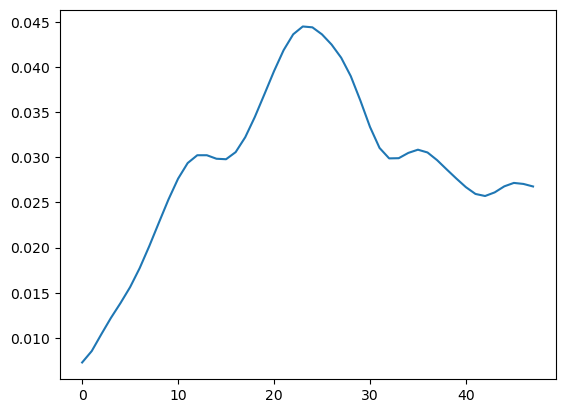

  0%|          | 3/3325 [00:00<03:02, 18.24it/s]

(12, 3)
(12, 3)
(12,)
(24, 3)


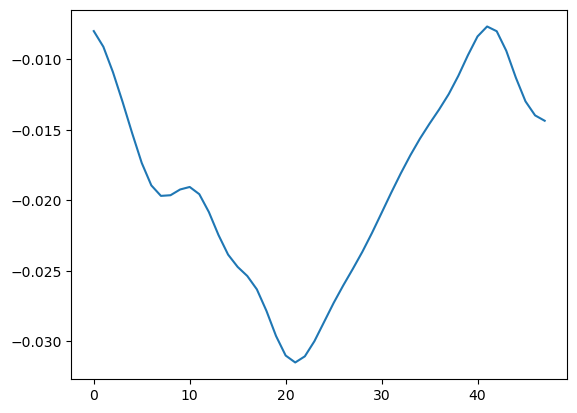

  0%|          | 7/3325 [00:00<02:34, 21.43it/s]

(12, 3)
(12, 3)
(12,)
(24, 3)


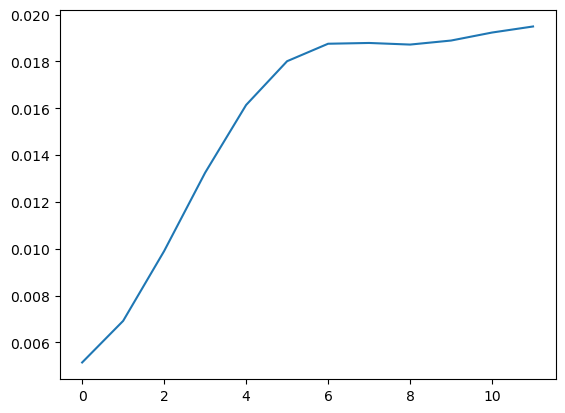

(12, 3)
(12, 3)
(12,)
(24, 3)


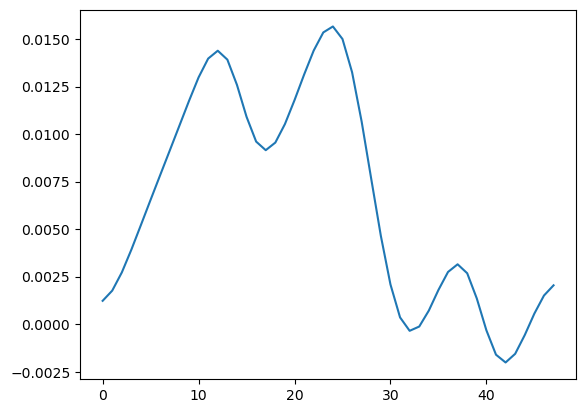

(12, 3)
(12, 3)
(12,)
(24, 3)


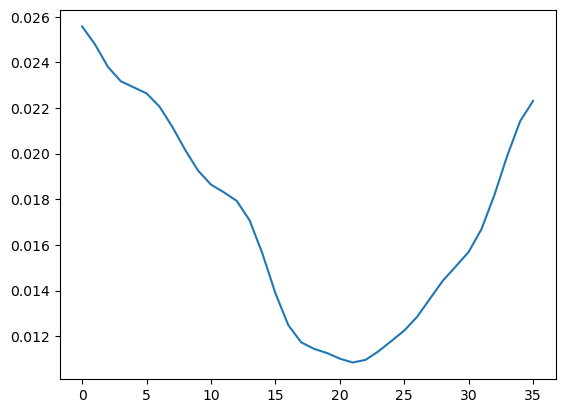

  0%|          | 10/3325 [00:00<05:06, 10.81it/s]

(12, 3)
(12, 3)
(12,)
(24, 3)


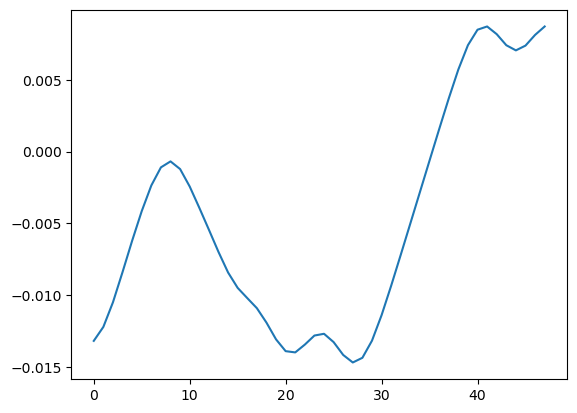

  0%|          | 13/3325 [00:00<04:08, 13.35it/s]

(12, 3)
(12, 3)
(12,)
(24, 3)


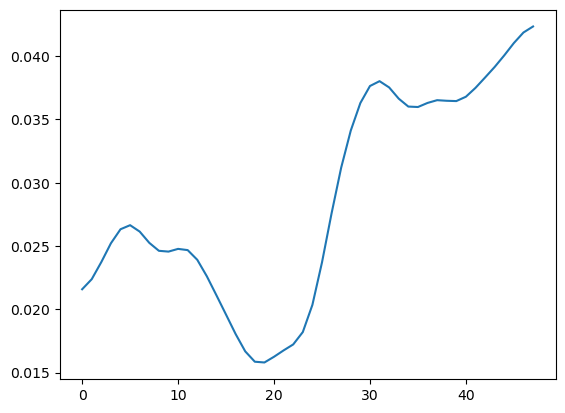

  0%|          | 15/3325 [00:01<04:41, 11.74it/s]

(12, 3)
(12, 3)
(12,)
(24, 3)


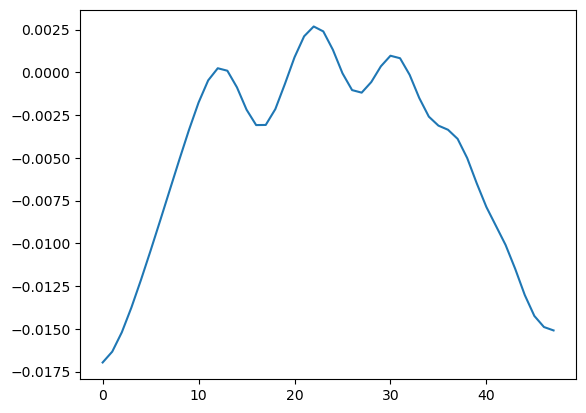

  1%|          | 17/3325 [00:01<04:17, 12.83it/s]


ValueError: Cannot take a larger sample than population when 'replace=False'

In [15]:
test_scores=[]
train_scores=[]
for i in tqdm(range(len(list_filt))):
    index_current=i
    Data=data_generator(list_filt,index_current,normalised=False,thresh=12)## 12 data points before and 12 for shift calculation
    if(Data!=None):
        train_data_,test_data=Data
        train_shape=floor(train_data_.shape[0]*0.8)
        train_data,shift_data=train_data[:train_shape],train_data[train_shape:]
        reg= LinearRegression().fit(train_data[:,:-1], train_data[:,-1])
        shifted_data_predict=reg.predict(shift_data[:,:-1])
        shifted_data=shift_data[:,-1]
        shift=shifted_data-shifted_data_predict
        # print(shifted_data_predict)
        # print(shifted_data)
        # print(shift)
        shift_model=shift_model_(reg,shift_data,train_data)
        if(index_current==25):
            print(jska)
        train_score=reg.score(train_data[:,:-1], train_data[:,-1])
        train_scores.append(train_score)

        test_score=reg.score(test_data[:,:-1], test_data[:,-1])
        test_scores.append(test_score)
        
    else:
        pass

In [29]:
test_scores=[]
train_scores=[]
shifts=[]
test_temps=[]
for i in tqdm(range(len(list_filt))):
    index_current=i
    Data=data_generator(list_filt,index_current,normalised=False,thresh=12)
    if(Data!=None):
        train_data,test_data=Data
        
        reg= LinearRegression().fit(train_data[:,:-1], train_data[:,-1])
        train_score=reg.score(train_data[:,:-1], train_data[:,-1])
        train_scores.append(train_score)
        shift= test_data[:,-1]- reg.predict(test_data[:,:-1])
        test_temps.append(test_data[:,-1])
        shifts.append(shift)
        test_score=reg.score(test_data[:,:-1], test_data[:,-1])
        test_scores.append(test_score)
        
    else:
        pass

100%|██████████| 3325/3325 [00:01<00:00, 3174.67it/s]


In [30]:
shifts=np.array(shifts)
test_temps=np.array(test_temps)

/home/paarthsachan/miniconda3/envs/battery/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/home/paarthsachan/miniconda3/envs/battery/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [33]:
test_scores=np.array(test_scores)
train_scores=np.array(train_scores)

In [41]:
shift_means=[]
for shift_arr in shifts:
    mean=np.mean(shift_arr)
    shift_means.append(mean)
shift_means=np.array(shift_means)

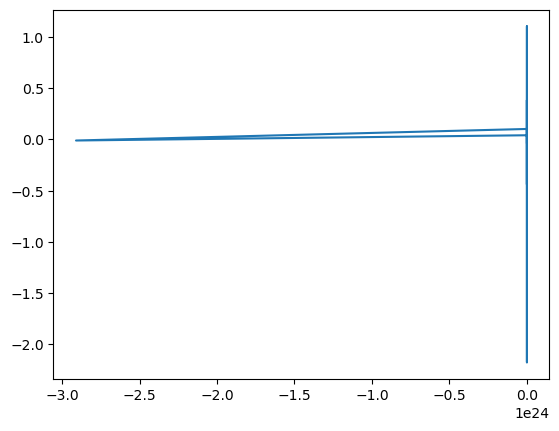

In [45]:
plt.plot(test_scores,shift_means)

In [82]:
anomaly_thresh=-10
anomaly_shift_train=[]
anomaly_train_scores=[]
anomaly_test_sscores=[]

In [83]:
test_scores=[]
train_scores=[]
shift_train=[]
for i in tqdm(range(len(list_filt))):
    index_current=i
    Data=data_generator(list_filt,index_current,normalised=False,thresh=12)## 12 data points before and 12 for shift calculation
    if(Data!=None):
        train_data_,test_data=Data
        train_shape=floor(train_data_.shape[0]*0.8)
        train_data,shift_data=train_data_[:train_shape],train_data_[train_shape:]

        reg= LinearRegression().fit(train_data[:,:-1], train_data[:,-1])
        shifted_data_predict=reg.predict(shift_data[:,:-1])
        shifted_data=shift_data[:,-1]
        shift=shifted_data-shifted_data_predict
        # print(shifted_data_predict)
        # print(shifted_data)
        # print(shift)
        shift_of_train=shift_returner_(reg,shift_data,train_data)
        train_score=reg.score(train_data[:,:-1], train_data[:,-1])
        test_score=reg.score(test_data[:,:-1], test_data[:,-1])
        if(test_score>anomaly_thresh):
            shift_train.append(shift_of_train)
            train_scores.append(train_score)
            test_scores.append(test_score)
        else:
            anomaly_shift_train.append(shift_of_train)
            anomaly_train_scores.append(train_score)
            anomaly_test_sscores.append(test_score)
        
    else:
        pass

100%|██████████| 3325/3325 [00:01<00:00, 2981.77it/s]


In [84]:
shift_train=np.array(shift_train)
test_scores=np.array(test_scores)
train_scores=np.array(train_scores)

anomaly_shift_train=np.array(anomaly_shift_train)
anomaly_train_scores=np.array(anomaly_train_scores)
anomaly_test_sscores=np.array(anomaly_test_sscores)


/home/paarthsachan/miniconda3/envs/battery/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/home/paarthsachan/miniconda3/envs/battery/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [85]:
print(shift_train.shape)
print(test_scores.shape)
print(train_scores.shape)

(766,)
(766,)
(766,)


In [86]:
shift_train_means=[]
for shift_arr in shift_train:
    mean=np.mean(shift_arr)
    shift_train_means.append(mean)
shift_train_means=np.array(shift_train_means)

In [87]:
anomaly_shift_train_means=[]
for shift_arr in anomaly_shift_train:
    mean=np.mean(shift_arr)
    anomaly_shift_train_means.append(mean)
anomaly_shift_train_means=np.array(anomaly_shift_train_means)

In [91]:
np.correlate(1-test_scores,np.abs(shift_train_means))

array([62.12232644])

In [93]:
np.correlate(1-train_scores,1-test_scores)

array([150.98452224])

In [94]:
np.correlate(1-train_scores,np.abs(shift_train_means))

array([1.12577319])

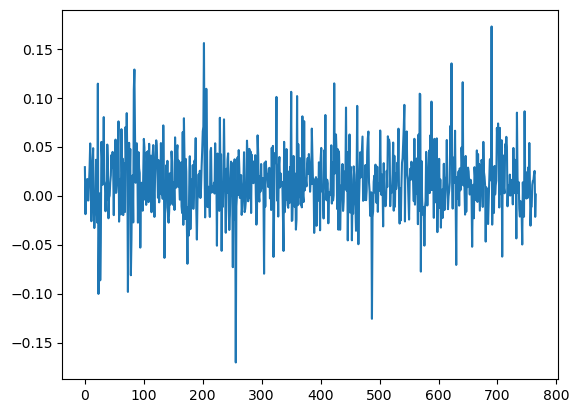

In [95]:
plt.plot(shift_train_means)

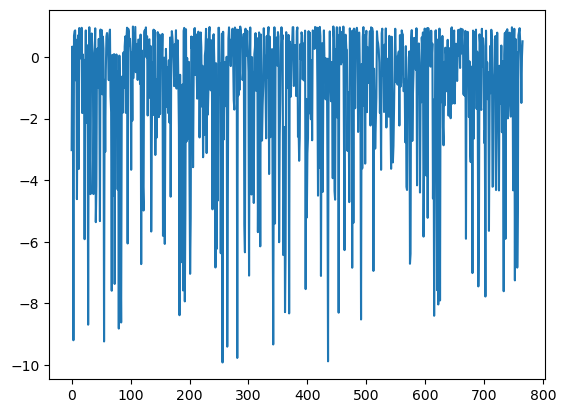

In [96]:
plt.plot(test_scores)

In [61]:
import numpy as np

# Create two arrays
x =shift_train_means
y = test_scores

# Calculate the IQR of x
q1, q3 = np.percentile(x, [25, 75])
iqr = q3 - q1

# Identify the lower and upper bounds for outliers
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

# Remove the outliers from x and y
x_filtered = x[(x >= lower_bound) & (x <= upper_bound)]
y_filtered = y[(x >= lower_bound) & (x <= upper_bound)]



In [62]:
np.correlate(x_filtered,y_filtered)

array([1.65687759e+23])